In [ ]:
! nvidia-smi

Mon Apr 11 17:26:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os, sys
import numpy as np
import torch
from torchvision import datasets, transforms
from sklearn.utils import shuffle
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import os.path
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import pandas as pd
import random
import pdb
import argparse,time
import math
from copy import deepcopy


In [ ]:
mnist_dir = '/content/drive/MyDrive/CSN-300 Lab based project/Gradient Projection Memory for continual learning/data'
pmnist_dir = '/content/drive/MyDrive/CSN-300 Lab based project/Gradient Projection Memory for continual learning/data/binary_pmnist'

In [ ]:
def get(seed=0, fixed_order=False, pc_valid=0.1):
    data = {}
    taskcla = []
    size = [1, 28, 28]

    nperm = 10  # 10 tasks
    seeds = np.array(list(range(nperm)), dtype=int)
    if not fixed_order:
        seeds = shuffle(seeds, random_state=seed)

    if not os.path.isdir(pmnist_dir):
        os.makedirs(pmnist_dir)
        # Pre-load
        # MNIST
        mean = (0.1307,)
        std = (0.3081,)
        dat = {}
        dat['train'] = datasets.MNIST(mnist_dir, train=True, download=True, transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize(mean, std)]))
        dat['test'] = datasets.MNIST(mnist_dir, train=False, download=True, transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize(mean, std)]))
        for i, r in enumerate(seeds):
            print(i, end=',')
            sys.stdout.flush()
            data[i] = {}
            data[i]['name'] = 'pmnist-{:d}'.format(i)
            data[i]['ncla'] = 10
            for s in ['train', 'test']:
                loader = torch.utils.data.DataLoader(dat[s], batch_size=1, shuffle=False)
                data[i][s] = {'x': [], 'y': []}
                for image, target in loader:
                    aux = image.view(-1).numpy()
                    aux = shuffle(aux, random_state=r * 100 + i)
                    image = torch.FloatTensor(aux).view(size)
                    data[i][s]['x'].append(image)
                    data[i][s]['y'].append(target.numpy()[0])

            # "Unify" and save
            for s in ['train', 'test']:
                data[i][s]['x'] = torch.stack(data[i][s]['x']).view(-1, size[0], size[1], size[2])
                data[i][s]['y'] = torch.LongTensor(np.array(data[i][s]['y'], dtype=int)).view(-1)
                torch.save(data[i][s]['x'],os.path.join(os.path.expanduser(pmnist_dir), 'data' + str(r) + s + 'x.bin'))
                torch.save(data[i][s]['y'],os.path.join(os.path.expanduser(pmnist_dir), 'data' + str(r) + s + 'y.bin'))
        print()

    else:

        # Load binary files
        for i, r in enumerate(seeds):
            data[i] = dict.fromkeys(['name', 'ncla', 'train', 'test'])
            data[i]['ncla'] = 10
            data[i]['name'] = 'pmnist-{:d}'.format(i)

            # Load
            for s in ['train', 'test']:
                data[i][s] = {'x': [], 'y': []}
                data[i][s]['x'] = torch.load(os.path.join(os.path.expanduser(pmnist_dir), 'data' + str(r) + s + 'x.bin'))
                data[i][s]['y'] = torch.load(os.path.join(os.path.expanduser(pmnist_dir), 'data' + str(r) + s + 'y.bin'))

    # Validation
    for t in data.keys():
        r=np.arange(data[t]['train']['x'].size(0))
        # r=np.array(shuffle(r,random_state=seed),dtype=int)
        r=np.array(r,dtype=int)
        nvalid=int(pc_valid*len(r))
        ivalid=torch.LongTensor(r[:nvalid])
        itrain=torch.LongTensor(r[nvalid:])
        data[t]['valid'] = {}
        data[t]['valid']['x']=data[t]['train']['x'][ivalid].clone()
        data[t]['valid']['y']=data[t]['train']['y'][ivalid].clone()
        data[t]['train']['x']=data[t]['train']['x'][itrain].clone()
        data[t]['train']['y']=data[t]['train']['y'][itrain].clone()

    # Others
    n = 0
    for t in data.keys():
        taskcla.append((t, data[t]['ncla']))
        n += data[t]['ncla']
    data['ncla'] = n

    return data, taskcla, size


In [ ]:
class MLPNet(nn.Module):
    def __init__(self, n_hidden=100, n_outputs=10):
        super(MLPNet, self).__init__()
        self.act=OrderedDict()
        self.lin1 = nn.Linear(784,n_hidden,bias=False)
        self.lin2 = nn.Linear(n_hidden,n_hidden, bias=False)
        self.fc1  = nn.Linear(n_hidden, n_outputs, bias=False)
        
    def forward(self, x):
        self.act['Lin1']=x
        x = self.lin1(x)        
        x = F.relu(x)
        self.act['Lin2']=x
        x = self.lin2(x)        
        x = F.relu(x)
        self.act['fc1']=x
        x = self.fc1(x)
        return x 


In [ ]:
def get_model(model):
    return deepcopy(model.state_dict())

In [ ]:
def set_model_(model,state_dict):
    model.load_state_dict(deepcopy(state_dict))
    return

In [ ]:
def train (args, model, device, x, y, optimizer,criterion):
    model.train()
    r=np.arange(x.size(0))
    np.random.shuffle(r)
    r=torch.LongTensor(r).to(device)
    # Loop batches
    for i in range(0,len(r),args.batch_size_train):
        if i+args.batch_size_train<=len(r): b=r[i:i+args.batch_size_train]
        else: b=r[i:]
        data = x[b].view(-1,28*28)
        data, target = data.to(device), y[b].to(device)
        optimizer.zero_grad()        
        output = model(data)
        loss = criterion(output, target)        
        loss.backward()
        optimizer.step()

In [ ]:
def train_projected (args, model,device,x,y,optimizer,criterion,feature_mat):
    model.train()
    r=np.arange(x.size(0))
    np.random.shuffle(r)
    r=torch.LongTensor(r).to(device)
    # Loop batches
    for i in range(0,len(r),args.batch_size_train):
        if i+args.batch_size_train<=len(r): b=r[i:i+args.batch_size_train]
        else: b=r[i:]
        data = x[b].view(-1,28*28)
        data, target = data.to(device), y[b].to(device)
        optimizer.zero_grad()        
        output = model(data)
        loss = criterion(output, target)         
        loss.backward()        
        # Gradient Projections 
        for k, (m,params) in enumerate(model.named_parameters()):
            sz =  params.grad.data.size(0)
            params.grad.data = params.grad.data - torch.mm(params.grad.data.view(sz,-1),\
                                                    feature_mat[k]).view(params.size())
        optimizer.step()

In [ ]:
def test (args, model, device, x, y, criterion):
    model.eval()
    total_loss = 0
    total_num = 0 
    correct = 0
    r=np.arange(x.size(0))
    np.random.shuffle(r)
    r=torch.LongTensor(r).to(device)
    with torch.no_grad():
        # Loop batches
        for i in range(0,len(r),args.batch_size_test):
            if i+args.batch_size_test<=len(r): b=r[i:i+args.batch_size_test]
            else: b=r[i:]
            data = x[b].view(-1,28*28)
            data, target = data.to(device), y[b].to(device)
            output = model(data)
            loss = criterion(output, target)
            pred = output.argmax(dim=1, keepdim=True) 
            
            correct    += pred.eq(target.view_as(pred)).sum().item()
            total_loss += loss.data.cpu().numpy().item()*len(b)
            total_num  += len(b)

    acc = 100. * correct / total_num
    final_loss = total_loss / total_num
    return final_loss, acc

In [ ]:
def get_representation_matrix (net, device, x, y=None): 
    # Collect activations by forward pass
    r=np.arange(x.size(0))
    np.random.shuffle(r)
    r=torch.LongTensor(r).to(device)
    b=r[0:300] # Take random training samples
    example_data = x[b].view(-1,28*28)
    example_data = example_data.to(device)
    example_out  = net(example_data)
    
    batch_list=[300,300,300] 
    mat_list=[] # list contains representation matrix of each layer
    act_key=list(net.act.keys())

    for i in range(len(act_key)):
        bsz=batch_list[i]
        act = net.act[act_key[i]].detach().cpu().numpy()
        activation = act[0:bsz].transpose()
        mat_list.append(activation)

    print('-'*30)
    print('Representation Matrix')
    print('-'*30)
    for i in range(len(mat_list)):
        print ('Layer {} : {}'.format(i+1,mat_list[i].shape))
    print('-'*30)
    return mat_list    

In [ ]:
def update_GPM (model, mat_list, threshold, feature_list=[],):
    print ('Threshold: ', threshold) 
    if not feature_list:
        # After First Task 
        for i in range(len(mat_list)):
            activation = mat_list[i]
            U,S,Vh = np.linalg.svd(activation, full_matrices=False)
            # criteria (Eq-5)
            sval_total = (S**2).sum()
            sval_ratio = (S**2)/sval_total
            r = np.sum(np.cumsum(sval_ratio)<threshold[i]) #+1  
            feature_list.append(U[:,0:r])
    else:
        for i in range(len(mat_list)):
            activation = mat_list[i]
            U1,S1,Vh1=np.linalg.svd(activation, full_matrices=False)
            sval_total = (S1**2).sum()
            # Projected Representation (Eq-8)
            act_hat = activation - np.dot(np.dot(feature_list[i],feature_list[i].transpose()),activation)
            U,S,Vh = np.linalg.svd(act_hat, full_matrices=False)
            # criteria (Eq-9)
            sval_hat = (S**2).sum()
            sval_ratio = (S**2)/sval_total               
            accumulated_sval = (sval_total-sval_hat)/sval_total
            
            r = 0
            for ii in range (sval_ratio.shape[0]):
                if accumulated_sval < threshold[i]:
                    accumulated_sval += sval_ratio[ii]
                    r += 1
                else:
                    break
            if r == 0:
                print ('Skip Updating GPM for layer: {}'.format(i+1)) 
                continue
            # update GPM
            Ui=np.hstack((feature_list[i],U[:,0:r]))  
            if Ui.shape[1] > Ui.shape[0] :
                feature_list[i]=Ui[:,0:Ui.shape[0]]
            else:
                feature_list[i]=Ui
    
    print('-'*40)
    print('Gradient Constraints Summary')
    print('-'*40)
    for i in range(len(feature_list)):
        print ('Layer {} : {}/{}'.format(i+1,feature_list[i].shape[1], feature_list[i].shape[0]))
    print('-'*40)
    return feature_list  

In [ ]:
def main(args):
    tstart=time.time()
    ## Device Setting 
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    ## Load PMNIST DATASET
    data,taskcla,inputsize=get(seed=args.seed, pc_valid=args.pc_valid)

    acc_matrix=np.zeros((10,10))
    criterion = torch.nn.CrossEntropyLoss()

    task_id = 0
    task_list = []
    
    for k,ncla in taskcla:
        # specify threshold hyperparameter
        threshold = np.array([0.95,0.99,0.99]) 
     
        print('*'*100)
        print('Task {:2d} ({:s})'.format(k,data[k]['name']))
        print('*'*100)
        xtrain=data[k]['train']['x']
        ytrain=data[k]['train']['y']
        xvalid=data[k]['valid']['x']
        yvalid=data[k]['valid']['y']
        xtest =data[k]['test']['x']
        ytest =data[k]['test']['y']
        task_list.append(k)

        lr = args.lr 
        print ('-'*40)
        print ('Task ID :{} | Learning Rate : {}'.format(task_id, lr))
        print ('-'*40)
        
        if task_id==0:
            model = MLPNet(args.n_hidden, args.n_outputs).to(device)
            print ('Model parameters ---')
            for k_t, (m, param) in enumerate(model.named_parameters()):
                print (k_t,m,param.shape)
            print ('-'*40)

            feature_list =[]
            optimizer = optim.SGD(model.parameters(), lr=lr)

            for epoch in range(1, args.n_epochs+1):
                # Train
                clock0=time.time()
                train(args, model, device, xtrain, ytrain, optimizer, criterion)
                clock1=time.time()
                tr_loss,tr_acc = test(args, model, device, xtrain, ytrain,  criterion)
                print('Epoch {:3d} | Train: loss={:.3f}, acc={:5.1f}% | time={:5.1f}ms |'.format(epoch,\
                                                            tr_loss,tr_acc, 1000*(clock1-clock0)),end='')
                # Validate
                valid_loss,valid_acc = test(args, model, device, xvalid, yvalid,  criterion)
                print(' Valid: loss={:.3f}, acc={:5.1f}% |'.format(valid_loss, valid_acc),end='')
                print()
            # Test
            print ('-'*40)
            test_loss, test_acc = test(args, model, device, xtest, ytest,  criterion)
            print('Test: loss={:.3f} , acc={:5.1f}%'.format(test_loss,test_acc))
            # Memory Update  
            mat_list = get_representation_matrix (model, device, xtrain, ytrain)
            feature_list = update_GPM (model, mat_list, threshold, feature_list)

        else:
            optimizer = optim.SGD(model.parameters(), lr=args.lr)
            feature_mat = []
            # Projection Matrix Precomputation
            for i in range(len(model.act)):
                Uf=torch.Tensor(np.dot(feature_list[i],feature_list[i].transpose())).to(device)
                print('Layer {} - Projection Matrix shape: {}'.format(i+1,Uf.shape))
                feature_mat.append(Uf)
            print ('-'*40)
            for epoch in range(1, args.n_epochs+1):
                # Train 
                clock0=time.time()
                train_projected(args, model,device,xtrain, ytrain,optimizer,criterion,feature_mat)
                clock1=time.time()
                tr_loss, tr_acc = test(args, model, device, xtrain, ytrain,  criterion)
                print('Epoch {:3d} | Train: loss={:.3f}, acc={:5.1f}% | time={:5.1f}ms |'.format(epoch,\
                                                        tr_loss, tr_acc, 1000*(clock1-clock0)),end='')
                # Validate
                valid_loss,valid_acc = test(args, model, device, xvalid, yvalid,  criterion)
                print(' Valid: loss={:.3f}, acc={:5.1f}% |'.format(valid_loss, valid_acc),end='')
                print()
            # Test 
            test_loss, test_acc = test(args, model, device, xtest, ytest,  criterion)
            print('Test: loss={:.3f} , acc={:5.1f}%'.format(test_loss,test_acc))  
                        # Memory Update 
            mat_list = get_representation_matrix (model, device, xtrain, ytrain)
            feature_list = update_GPM (model, mat_list, threshold, feature_list)
        
        # save accuracy 
        jj = 0 
        for ii in np.array(task_list)[0:task_id+1]:
            xtest =data[ii]['test']['x']
            ytest =data[ii]['test']['y'] 
            _, acc_matrix[task_id,jj] = test(args, model, device, xtest, ytest,criterion) 
            jj +=1
        print('Accuracies =')
        for i_a in range(task_id+1):
            print('\t',end='')
            for j_a in range(acc_matrix.shape[1]):
                print('{:5.1f}% '.format(acc_matrix[i_a,j_a]),end='')
            print()
        # update task id 
        task_id +=1
    print('-'*50)
    # Simulation Results 
    print ('Task Order : {}'.format(np.array(task_list)))
    print ('Final Avg Accuracy: {:5.2f}%'.format(acc_matrix[-1].mean())) 
    bwt=np.mean((acc_matrix[-1]-np.diag(acc_matrix))[:-1]) 
    print ('Backward transfer: {:5.2f}%'.format(bwt))
    print('[Elapsed time = {:.1f} ms]'.format((time.time()-tstart)*1000))
    print('-'*50)
    # Plots
    array = acc_matrix
    df_cm = pd.DataFrame(array, index = [i for i in ["T1","T2","T3","T4","T5","T6","T7","T8","T9","T10"]],
                      columns = [i for i in ["T1","T2","T3","T4","T5","T6","T7","T8","T9","T10"]])
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 10})
    plt.show()

Arguments =
	batch_size_train: 10
	batch_size_test: 64
	n_epochs: 5
	seed: 2
	pc_valid: 0.1
	lr: 0.01
	momentum: 0.9
	lr_min: 1e-05
	lr_patience: 6
	lr_factor: 2
	n_hidden: 100
	n_outputs: 10
	n_tasks: 10


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/CSN-300 Lab based project/Gradient Projection Memory for continual learning/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/CSN-300 Lab based project/Gradient Projection Memory for continual learning/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/CSN-300 Lab based project/Gradient Projection Memory for continual learning/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/CSN-300 Lab based project/Gradient Projection Memory for continual learning/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/CSN-300 Lab based project/Gradient Projection Memory for continual learning/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/CSN-300 Lab based project/Gradient Projection Memory for continual learning/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/CSN-300 Lab based project/Gradient Projection Memory for continual learning/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/CSN-300 Lab based project/Gradient Projection Memory for continual learning/data/MNIST/raw

0,1,2,3,4,5,6,7,8,9,
****************************************************************************************************
Task  0 (pmnist-0)
****************************************************************************************************
----------------------------------------
Task ID :0 | Learning Rate : 0.01
----------------------------------------
Model parameters ---
0 lin1.weight torch.Size([100, 784])
1 lin2.weight torch.Size([100, 100])
2 fc1.weight torch.Size([10, 100])
----------------------------------------
Epoch   1 | Train: loss=0.173, acc= 94.9% | time=6552.7ms | Valid: loss=0.172, acc= 95.0% |
Epoch   2 | Train: loss=0.111, acc= 96.7% | time=6413.6ms | Valid: loss=0.121, acc= 96.4% |
Epoch   3 | Train:

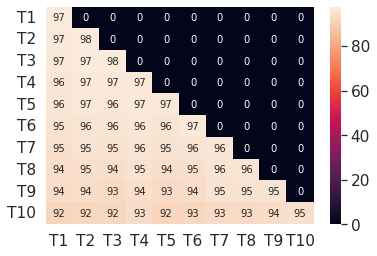

In [ ]:
if __name__ == "__main__":
    # Training parameters
    parser = argparse.ArgumentParser(description='Sequential PMNIST with GPM')
    parser.add_argument('--batch_size_train', type=int, default=10, metavar='N',
                        help='input batch size for training (default: 10)')
    parser.add_argument('--batch_size_test', type=int, default=64, metavar='N',
                        help='input batch size for testing (default: 64)')
    parser.add_argument('--n_epochs', type=int, default=5, metavar='N',
                        help='number of training epochs/task (default: 5)')
    parser.add_argument('--seed', type=int, default=2, metavar='S',
                        help='random seed (default: 2)')
    parser.add_argument('--pc_valid',default=0.1,type=float,
                        help='fraction of training data used for validation')
    # Optimizer parameters
    parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                        help='learning rate (default: 0.01)')
    parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                        help='SGD momentum (default: 0.9)')
    parser.add_argument('--lr_min', type=float, default=1e-5, metavar='LRM',
                        help='minimum lr rate (default: 1e-5)')
    parser.add_argument('--lr_patience', type=int, default=6, metavar='LRP',
                        help='hold before decaying lr (default: 6)')
    parser.add_argument('--lr_factor', type=int, default=2, metavar='LRF',
                        help='lr decay factor (default: 2)')
    # Architecture
    parser.add_argument('--n_hidden', type=int, default=100, metavar='NH',
                        help='number of hidden units in MLP (default: 100)')
    parser.add_argument('--n_outputs', type=int, default=10, metavar='NO',
                        help='number of output units in MLP (default: 10)')
    parser.add_argument('--n_tasks', type=int, default=10, metavar='NT',
                        help='number of tasks (default: 10)')

    args, unknown = parser.parse_known_args()
    print('='*100)
    print('Arguments =')
    for arg in vars(args):
        print('\t'+arg+':',getattr(args,arg))
    print('='*100)

    main(args)